In [1]:
import pandas as pd
import pandas_datareader as pdr
import altair as alt
import quandl
import numpy as np
from sklearn.model_selection import train_test_split
authtoken="AmT6hbzjx59sQAvKde2L"

In [2]:
start, end = '1970-01-01','2019-08-31'
labor_index = pdr.get_data_fred(['USPRIV',
                          'CE16OV',
                          'UNEMPLOY',
                          'AWHI'], start=start, end=end)
initial_jobless_claims = pdr.get_data_fred(['ICSA'], start=start, end=end)
ism_nonmfg  = quandl.get('FRED/NMFCI', authtoken=authtoken, start=start, end=end)
ism_mfg = quandl.get('ISM/MAN_PMI', authtoken=authtoken, start=start, end=end)
stock_mkt = pdr.DataReader('^GSPC', data_source='yahoo', start=start, end=end)['Adj Close']
spot_oil = pdr.get_data_fred('WTISPLC', start=start, end=end)
yield_curve = pdr.get_data_fred(['GS10','TB3MS'], start=start, end=end)
consumer_index = pdr.get_data_fred(['PCE','PCEPI','RSALES','RRSFS'], start=start, end=end)
corp_bond_spread = pdr.get_data_fred(['AAA','BAA'], start=start, end=end)
real_money_base = pdr.get_data_fred(['AMBSL','CPIAUCSL'], start=start, end=end)
consumer_sentiment = pdr.get_data_fred('UMCSENT', start=start, end=end)
indust_prod = pdr.get_data_fred('INDPRO', start=start, end=end)
new_permits = pdr.get_data_fred('PERMIT', start=start, end=end)
real_man_trd_sales = pdr.get_data_fred('CMRMTSPL', start=start, end=end)
real_pi = pdr.get_data_fred('W875RX1', start=start, end=end)
usrec = pdr.get_data_fred('USREC', start=start, end=end)

## 1 Labor Market Index

In [3]:
initial_jobless_claims = initial_jobless_claims.resample('MS').mean() # resample weekly data to monthly average
labor_index = labor_index.join(initial_jobless_claims,how='left') # merge all labor data together
labor_index['employ_ratio'] = labor_index['CE16OV'] / labor_index['UNEMPLOY'] # create employment to unemployment ratio
labor_index.drop(['CE16OV','UNEMPLOY'], axis=1, inplace=True) # drop unnecessary columns
labor_index = labor_index.pct_change(12).dropna() # create rolling 12 month % change
labor_index.ICSA = -labor_index.ICSA # invert initial jobless claims percent change
labor_market_index = pd.DataFrame(labor_index.mean(axis=1),columns=['LMI'])

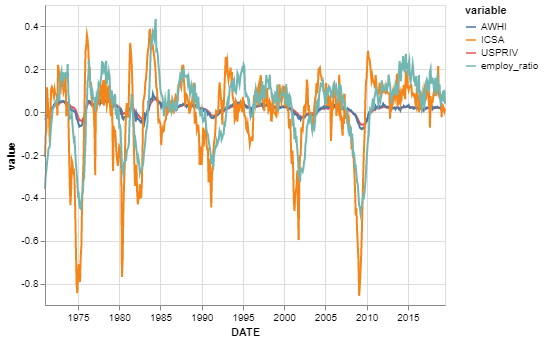

In [4]:
data = labor_index.reset_index().melt('DATE')

alt.Chart(data).mark_line().encode(
    x='DATE',
    y='value',
    color='variable'
)


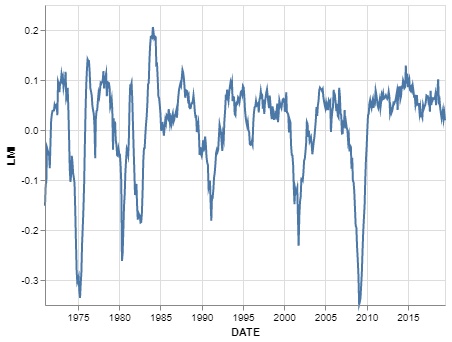

In [5]:
alt.Chart(labor_market_index.reset_index()).mark_line().encode(
    x='DATE:T',
    y='LMI'
)

## 2 ISM NonManufacturing Index

In [6]:

ism_nonmfg = (ism_nonmfg - 50) / 50
ism_nonmfg.columns = ['ISMNonManufacturing']

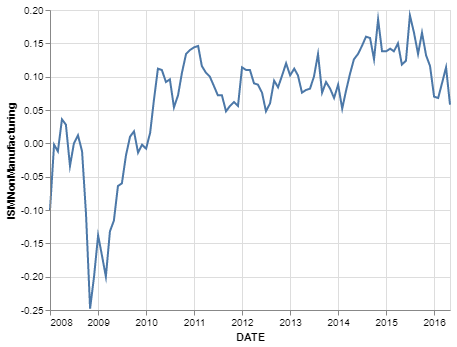

In [7]:
alt.Chart(ism_nonmfg.reset_index()).mark_line().encode(
    x='DATE:T',
    y='ISMNonManufacturing:Q'
)

## 3 Stock Market

In [8]:
stock_mkt = stock_mkt.pct_change(252).dropna().resample('MS').mean()

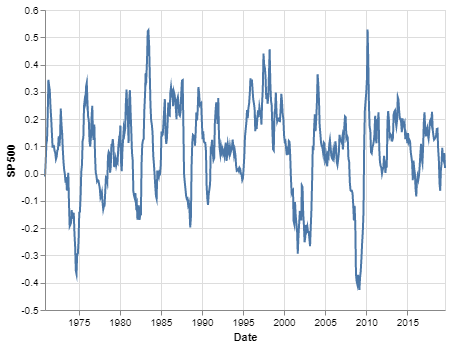

In [9]:
alt.Chart(stock_mkt.reset_index(name='SP500')).mark_line().encode(
    x='Date:T',
    y='SP500:Q'
)

## 4 ISM Manufacturing Index

In [10]:
ism_mfg = ism_mfg.loc[start:]
ism_mfg = (ism_mfg - 50) / 50
ism_mfg.columns = ['ISMManufacturing']

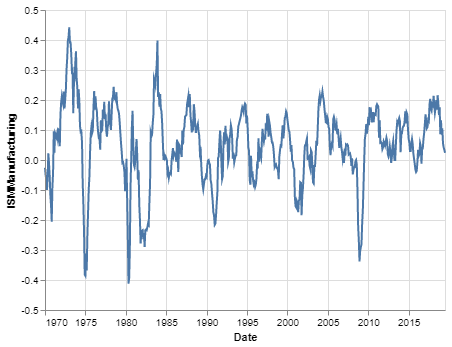

In [11]:
alt.Chart(ism_mfg.reset_index()).mark_line().encode(
    x='Date:T',
    y='ISMManufacturing:Q'
)

## 5 Spot Oil

In [12]:
spot_oil = - spot_oil.pct_change(12).dropna() # converting to rolling 12 month % change AND inverting

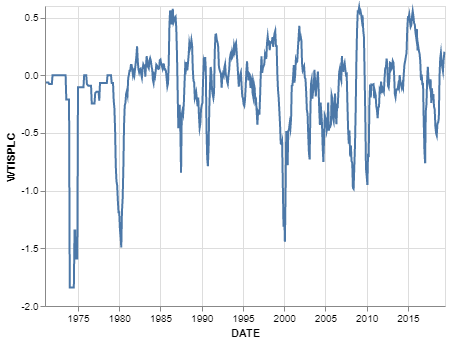

In [13]:
alt.Chart(spot_oil.reset_index()).mark_line().encode(
    x='DATE:T',
    y='WTISPLC:Q'
)

## 6 Yield Curve

In [14]:
yield_curve = yield_curve.GS10 - yield_curve.TB3MS

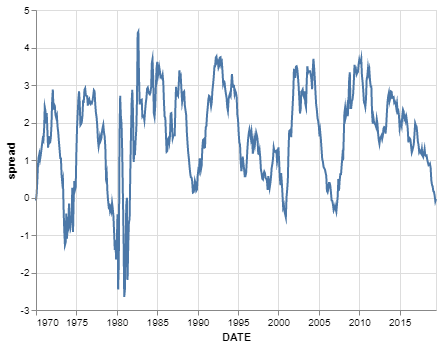

In [15]:
alt.Chart(yield_curve.reset_index(name='spread')).mark_line().encode(
    x='DATE:T',
    y='spread:Q'
)

## 7 Consumer Spending

In [16]:
# align series so RSALES and RRSFS overlap when RRSFS starts
# otherwise the perecent change calculation will have a jump in it
# split into two series for cleaner syntax
rsales = consumer_index.RSALES
rrsfs = consumer_index.RRSFS
idx = rrsfs[rrsfs.isna()].index[-1] + pd.Timedelta('31 D') # find location wherer RRSFS starts
consumer_index.RSALES = rsales + (rrsfs.loc[idx] - rsales.loc[idx]) # adjust RSALES upwards so that it aligns when RRSFS starts
# join the two series together: use RSALES until RRSFS starts
consumer_index['RealRetailSales'] = pd.concat([consumer_index.RSALES.loc[:idx-pd.Timedelta('31 D')],
                                               consumer_index.RRSFS.loc[idx:]])

# Deflate PCE to create a real series
consumer_index['RealPersonalConsExpend'] = consumer_index.PCE / consumer_index.PCEPI
consumer_index.drop(['PCE','PCEPI','RSALES','RRSFS'], axis=1, inplace=True)
# Create 12 month rolling % change and create aggregate index: mean of RealPersonalConsExpend and RealRetailSales
consumer_index = consumer_index.pct_change(12).dropna()
consumer_index['ConsumerSpendingIndex'] = (consumer_index.RealPersonalConsExpend + consumer_index.RealRetailSales) / 2 
consumer_index.drop(['RealPersonalConsExpend','RealRetailSales'],axis=1, inplace=True)

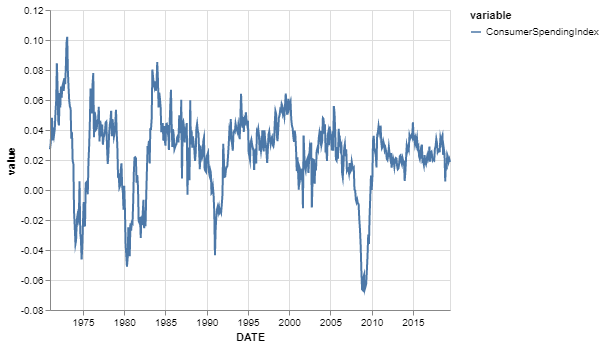

In [17]:
data = consumer_index.reset_index().melt('DATE')

alt.Chart(data).mark_line().encode(
    x='DATE',
    y='value',
    color='variable'
)

## 8 Corporate Bond Spread

In [18]:
corp_bond_spread['CorpBondSpread'] = corp_bond_spread.BAA - corp_bond_spread.AAA
corp_bond_spread.drop(['AAA','BAA'], axis=1, inplace=True)
corp_bond_spread = corp_bond_spread.pct_change(12).dropna()

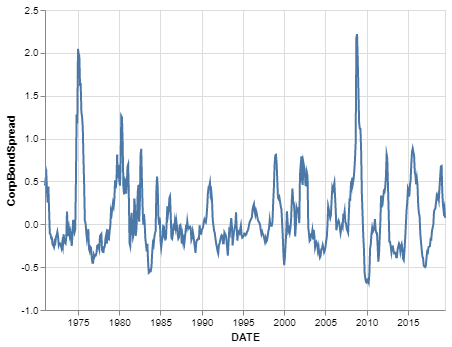

In [19]:
alt.Chart(corp_bond_spread.reset_index()).mark_line().encode(
    x='DATE:T',
    y='CorpBondSpread:Q'
)

## 9 Real Money Base

In [20]:
real_money_base['M0MoneyBase'] = real_money_base.AMBSL / real_money_base.CPIAUCSL
real_money_base.drop(['AMBSL','CPIAUCSL'], axis=1, inplace=True)
real_money_base = real_money_base.pct_change(12).dropna()


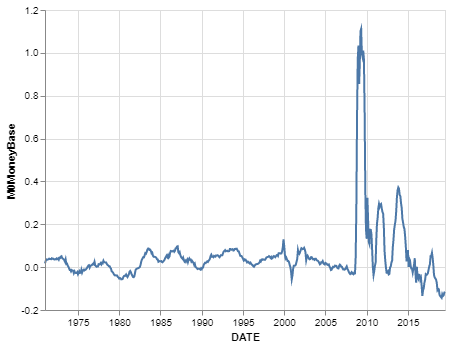

In [21]:
alt.Chart(real_money_base.reset_index()).mark_line().encode(
    x='DATE:T',
    y='M0MoneyBase'
)

## 10 Consumer Sentiment

In [22]:
consumer_sentiment = consumer_sentiment.pct_change(12).dropna()

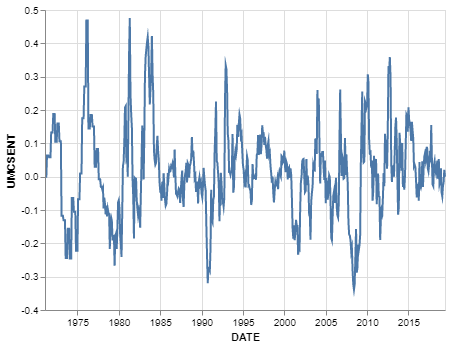

In [23]:
alt.Chart(consumer_sentiment.reset_index()).mark_line().encode(
    x='DATE:T',
    y='UMCSENT'
)

## 11 Industrial Production

In [24]:
indust_prod = indust_prod.pct_change(12).dropna()

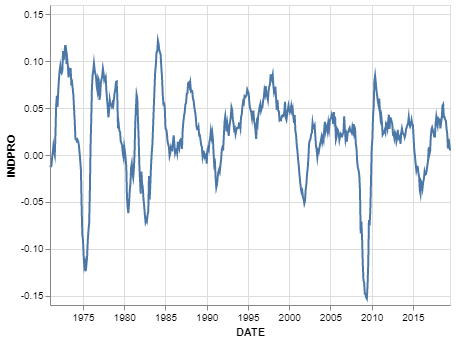

In [25]:
alt.Chart(indust_prod.reset_index()).mark_line().encode(
    x='DATE:T',
    y='INDPRO'
)

## 12 New Residential Building Permits

In [26]:
new_permits = new_permits.pct_change(12).dropna()

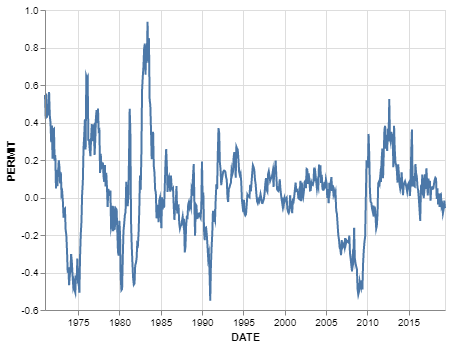

In [27]:
alt.Chart(new_permits.reset_index()).mark_line().encode(
    x='DATE:T',
    y='PERMIT:Q'
)

## 13 Real Manufacturing and Trade Sales

In [28]:
real_man_trd_sales = real_man_trd_sales.pct_change(12).dropna()

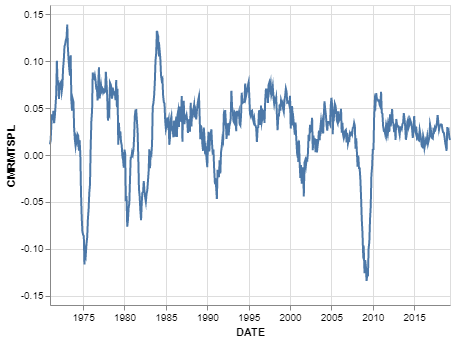

In [29]:
alt.Chart(real_man_trd_sales.reset_index()).mark_line().encode(
    x='DATE:T',
    y='CMRMTSPL:Q'
)

## 14 Real Personal Income Ex Current Transfer Receipts

In [30]:
real_pi = real_pi.pct_change(12).dropna()

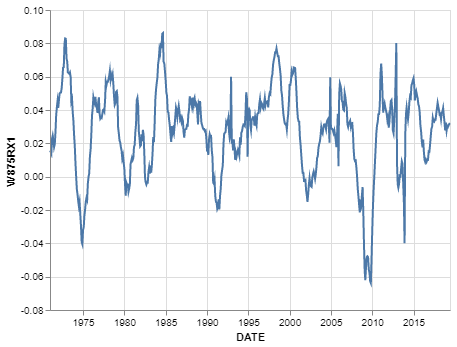

In [31]:
alt.Chart(real_pi.reset_index()).mark_line().encode(
    x='DATE:T',
    y='W875RX1:Q'
)

In [32]:
data = pd.concat([labor_market_index, 
#            ism_nonmfg,
           ism_mfg,
           stock_mkt,
           spot_oil,
           yield_curve,
           consumer_index,
           corp_bond_spread,
           real_money_base,
           consumer_sentiment,
           indust_prod,
           new_permits,
           real_man_trd_sales,
           real_pi,
                  usrec
          ],axis=1)
data.columns=[
    'LaborMarketIndex',
#     'ISMNonManufacturing',
    'ISMManufacturing',
    'SP500',
    'SpotOil',
    'YieldCurve',
    'ConsumerSpendingIndex',
    'CorpBondSpread',
    'M0MoneyBase',
    'ConsumerSentiment',
    'IndustrialProduction',
    'NewPermits',
    'RealManufacturingTradeSales',
    'RealPersonalIncome',
    'Recession'
]
data = data.loc['1972-02-01':]

In [33]:
data.to_csv('nowcastingdata')